In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo, TimeDelta
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst_efd_client import EfdClient
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client = makeEfdClient()

In [3]:
# Select data from a given date
dayObs = 20230629
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]


In [9]:
event_time=Time("2023-06-27 12:10:17.733")


<Time object: scale='utc' format='iso' value=2023-06-27 12:10:14.733>

In [10]:
df_mtmount_el_0=getEfdData(client,'lsst.sal.MTMount.elevation',  begin=event_time, end=event_time, prePadding=3, postPadding=4)

In [12]:
df_mtmount_el_0=getEfdData(client,'lsst.sal.MTMount.elevation',  begin=event_time, end=event_time, prePadding=3, postPadding=4)
df_m1m3_hp_0=getEfdData(client,"lsst.sal.MTM1M3.hardpointActuatorData",  begin=event_time, end=event_time, prePadding=3, postPadding=4)

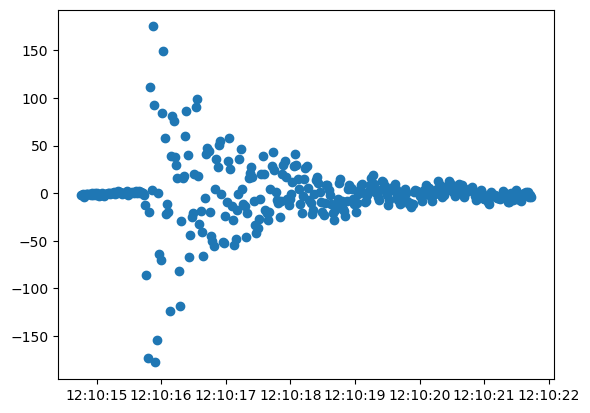

In [14]:
plt.scatter(df_m1m3_hp_0.index,df_m1m3_hp_0["measuredForce0"])

In [16]:
df_m1m3_hp_0.to_csv("../data/example_osc.csv", index=False)

In [24]:
timestep=0.02
def get_freq_psd(vals,timestep):
    meanval=np.mean(vals)
    signal= vals - meanval
    N=len(signal)
    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2
    frequencies = np.fft.rfftfreq(N, timestep)
    return(frequencies, psd)

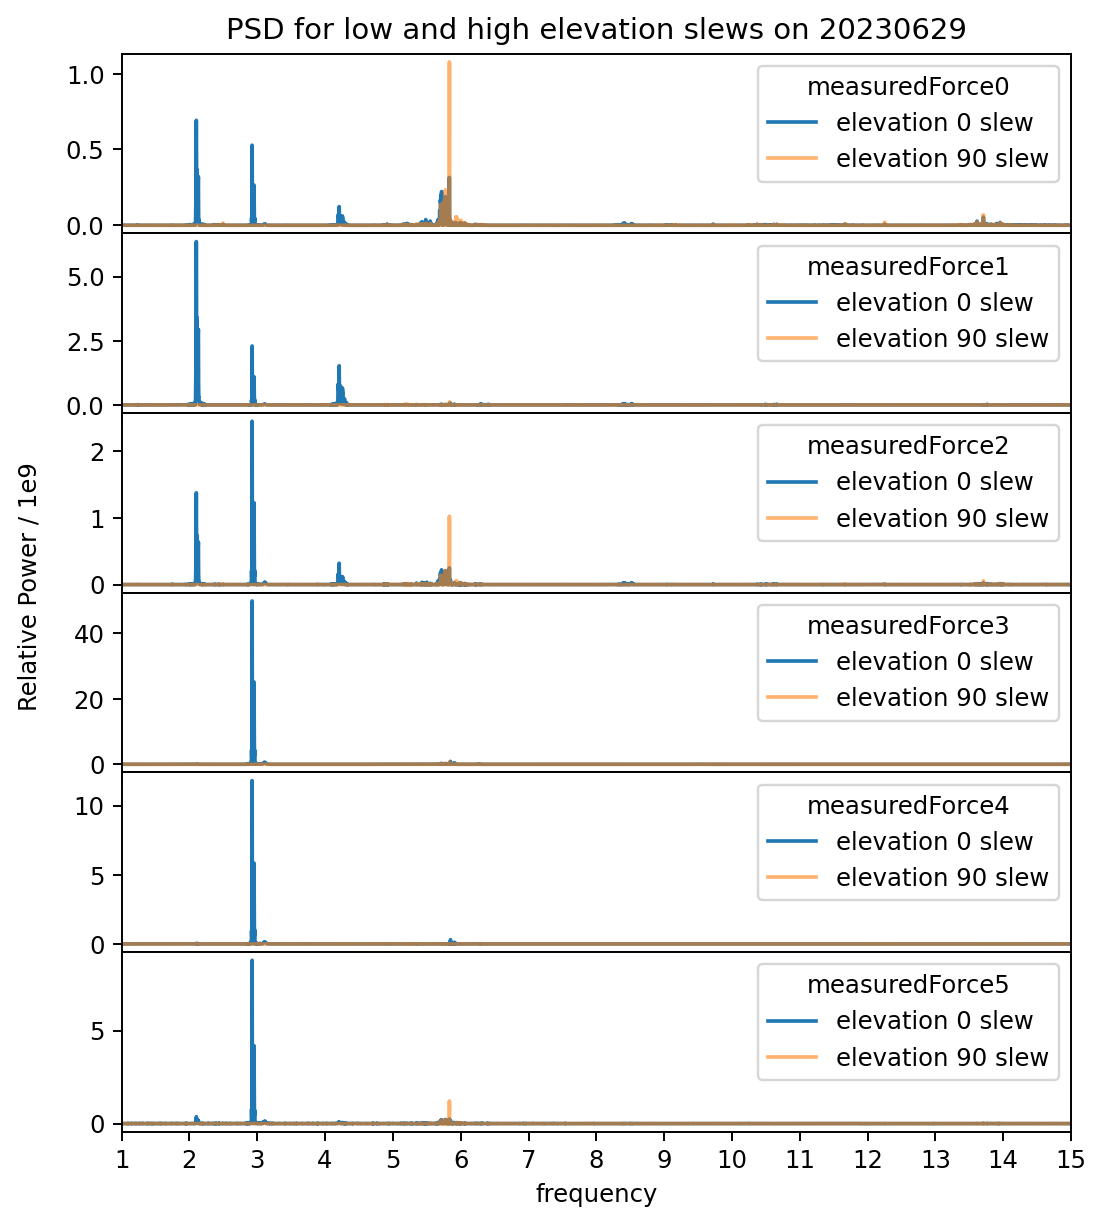

In [59]:
fig,axs=plt.subplots(6,dpi=175, figsize=(7,8), sharex=True)
for i in range(6):
    ax=axs[i]
    el_0=get_freq_psd(df_m1m3_hp_0[f'measuredForce{i}'], timestep)
    el_90=get_freq_psd(df_m1m3_hp_90[f'measuredForce{i}'], timestep)
    ax.plot(el_0[0], el_0[1]/1e9, label="elevation 0 slew")
    ax.plot(el_90[0], el_90[1]/1e9, alpha=0.6, label="elevation 90 slew")
    ax.legend(title=f'measuredForce{i}')
axs[5].set_xticks(np.concatenate([np.arange(1,16)]))
axs[5].set_xlabel("frequency")
axs[5].set_xlim(1,15)
plt.subplots_adjust(hspace=0)
axs[0].set_title(f"PSD for low and high elevation slews on {dayObs}")
fig.text(0.04, 0.5, 'Relative Power / 1e9', va='center', rotation='vertical')
plt.savefig("../plots/low_elevation_regular_oscillations.png")

In [97]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [155]:
df_m1m3_ims_0=getEfdData(client,"lsst.sal.MTM1M3.imsData",  event=slews[22], prePadding=15*60,postPadding=-5*60)
df_m1m3_ims_0=df_m1m3_ims_0.iloc[-400:,:]

Text(0, 0.5, 'Rotation offset [arcsec]')

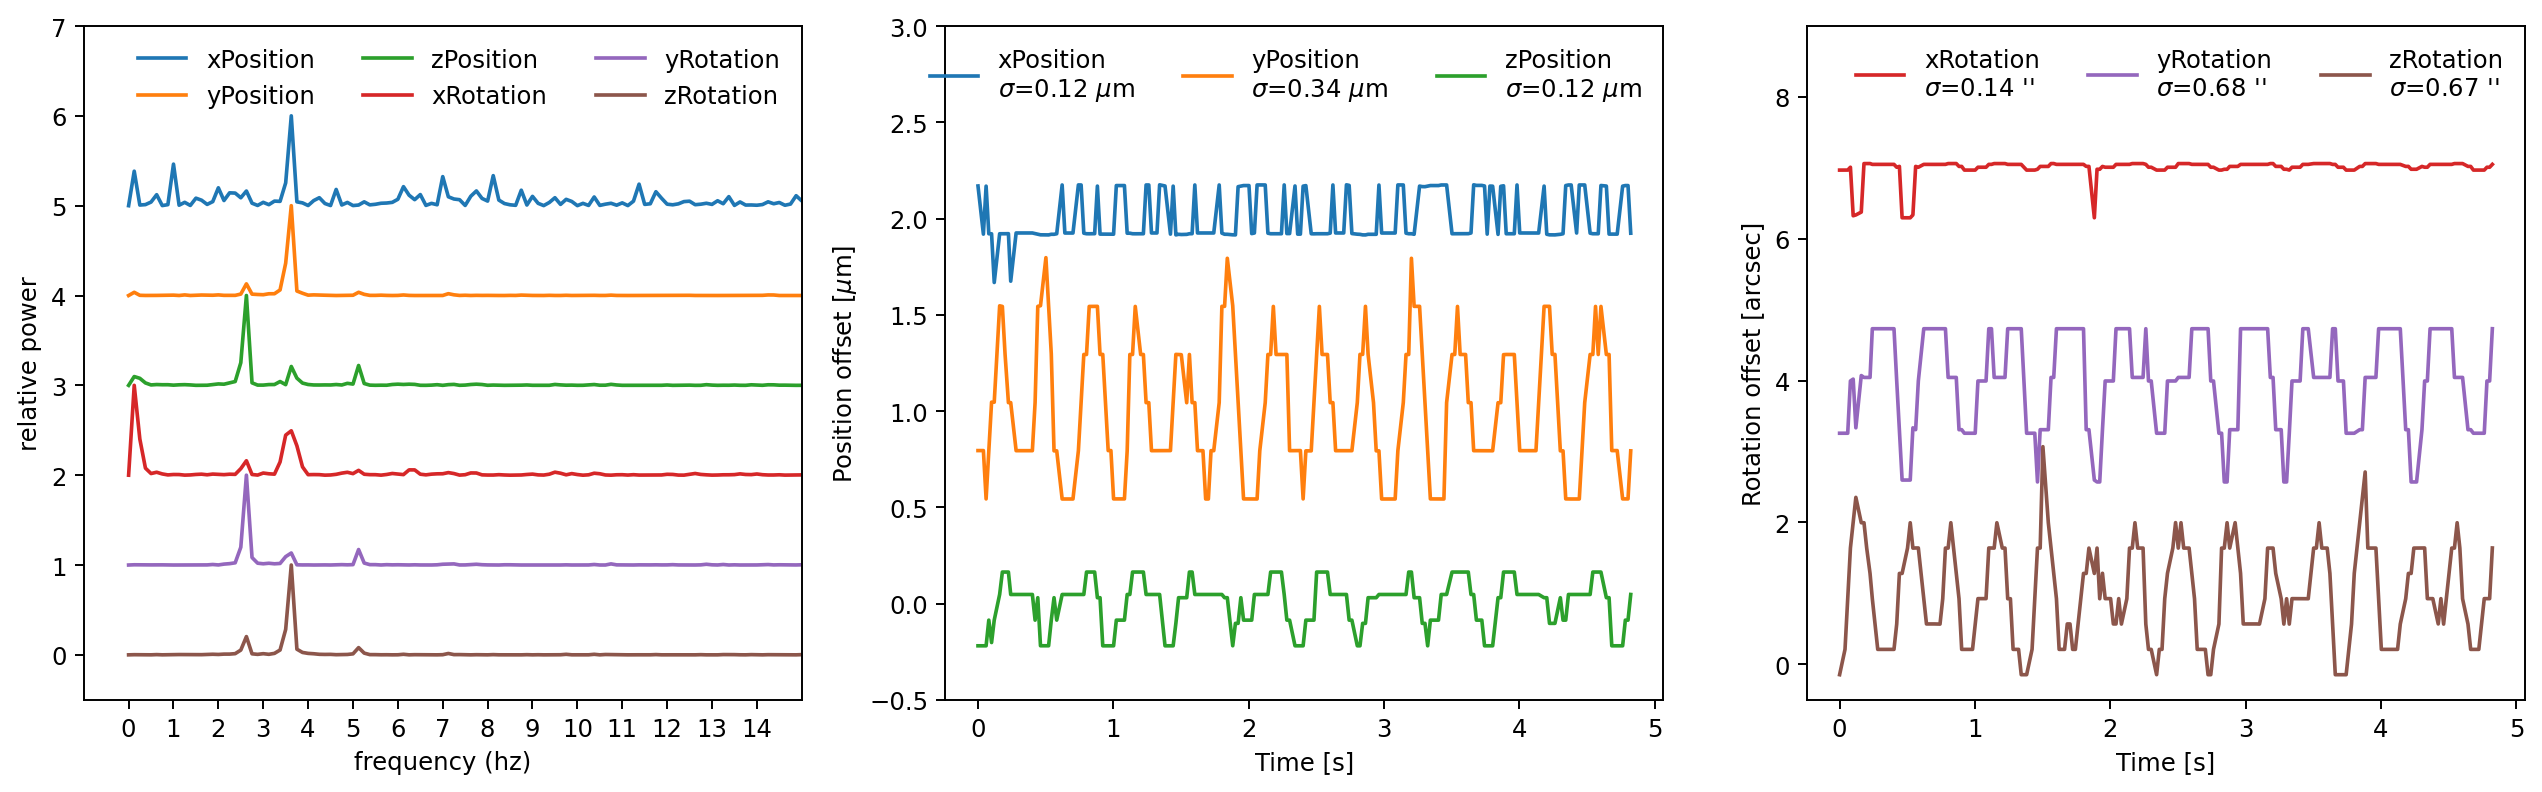

In [188]:
fig, axs=plt.subplots(1,3, dpi=175, figsize=(18,5))
ax=axs[0]
for i, column in enumerate(pos_columns + rot_columns):
    freq, psd = get_freq_psd(df_m1m3_ims_0[column], timestep)
    ax.plot(freq, psd/np.max(psd) - i + 5, label=column)
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_ylim(-0.5,7)
ax.set_xlim(-1,15)
ax.set_xticks(np.arange(15))
ax.set_xlabel("frequency (hz)")
ax.set_ylabel("relative power")

ax=axs[1]
for i, column in enumerate(pos_columns):
    
    meanval=np.mean(df_m1m3_ims_0[column][-200:])
    times=Time(df_m1m3_ims_0["private_sndStamp"], format="unix_tai").unix
    ax.plot(times[-200:]-times[-200],
            (df_m1m3_ims_0[column][-200:]-meanval) * 1e6 - i + 2, 
            label=f"{column}\n$\sigma$={np.std(df_m1m3_ims_0[column][-200:])*1e6:0.2f} $\mu$m")
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_ylim(-0.5,3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position offset [$\mu$m]")


ax=axs[2]
color_list=["tab:red","tab:purple","tab:brown"]
for i, column in enumerate(rot_columns):
    vals=np.rad2deg(df_m1m3_ims_0[column][-200:]) * 60 * 60
    meanval=np.mean(vals)
    times=Time(df_m1m3_ims_0["private_sndStamp"], format="unix_tai").unix
    ax.plot(times[-200:]-times[-200],
            (vals-meanval) - 3 * i + 7, c=color_list[i],
            label=f"{column}\n$\sigma$={np.std(vals):0.2f} '' ")
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_ylim(-0.5,9)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Rotation offset [arcsec]")

In [190]:
df_mtmount_el_0=getEfdData(client,'lsst.sal.MTMount.elevation',   event=slews[22], prePadding=15*60,postPadding=-5*60)
df_m1m3_hp_0=getEfdData(client,"lsst.sal.MTM1M3.hardpointActuatorData",   event=slews[22], prePadding=15*60,postPadding=-5*60)



Text(0, 0.5, 'Force offset [N]')

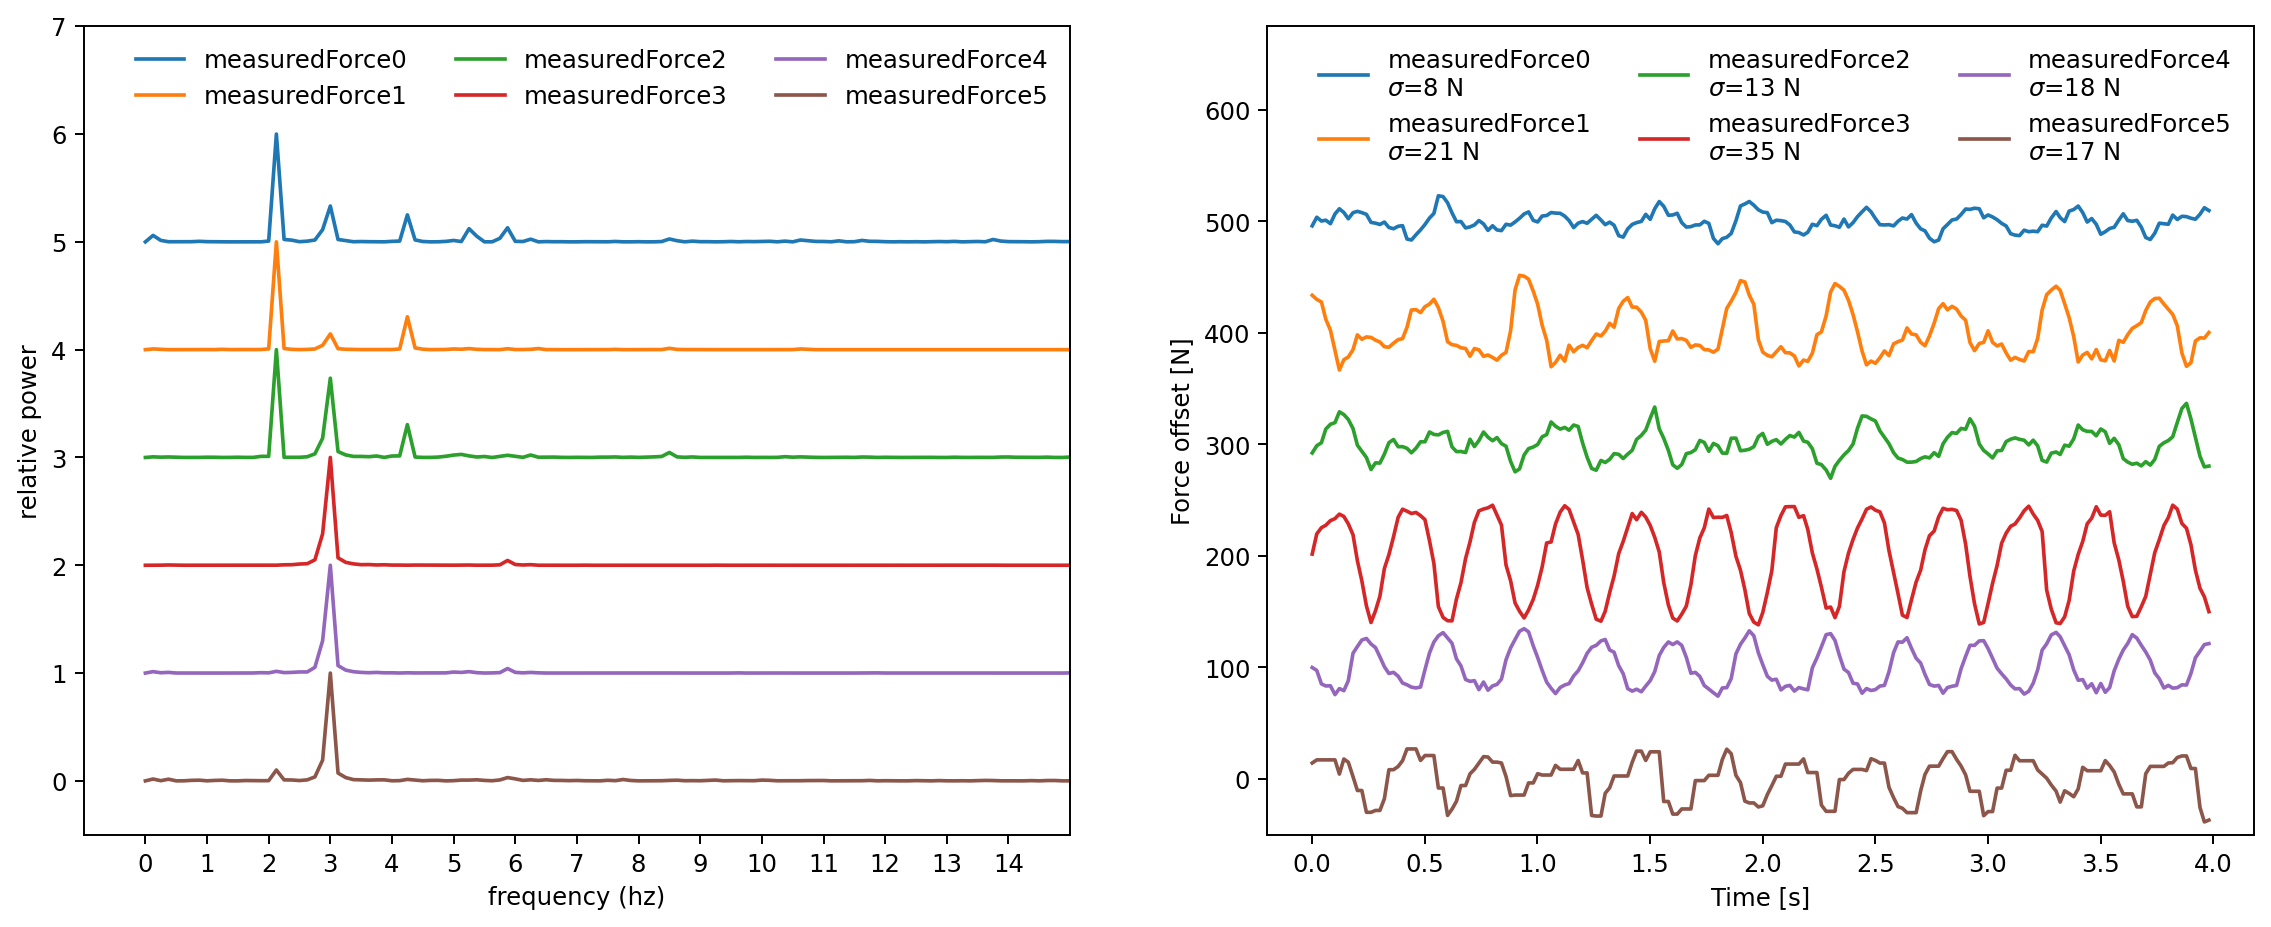

In [217]:
fig, axs=plt.subplots(1,2, dpi=175, figsize=(16,6))
ax=axs[0]
for i, column in enumerate(pos_columns + rot_columns):
    vals=df_m1m3_hp_0[f'measuredForce{i}'][-400:]
    freq, psd = get_freq_psd(vals-vals.mean(), timestep)
    ax.plot(freq, psd/np.max(psd) - i + 5, label=f'measuredForce{i}')
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_ylim(-0.5,7)
ax.set_xlim(-1,15)
ax.set_xticks(np.arange(15))
ax.set_xlabel("frequency (hz)")
ax.set_ylabel("relative power")

ax=axs[1]
for i, column in enumerate(pos_columns + rot_columns):
    vals=df_m1m3_hp_0[f'measuredForce{i}'][-200:]
    times=Time(df_m1m3_hp_0["private_sndStamp"][-200:], format="unix_tai").unix
    ax.plot(times-times[0],
            (vals-vals.mean()) - i * 100 + 500, 
            label=f"measuredForce{i}\n"+f"$\sigma$={np.std(vals-vals.mean()):0.0f} N")
ax.legend(ncol=3, edgecolor="None", facecolor="None")
ax.set_ylim(-50, 675)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Force offset [N]")
# for i in range(6):
#     ax=axs[i]
#     el_0=

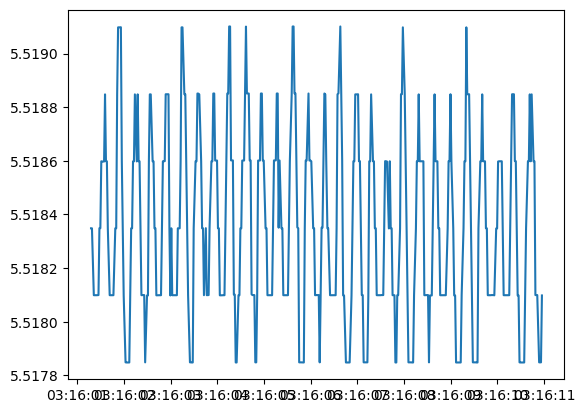

In [100]:
plt.plot(Time(df_m1m3_ims_0["private_sndStamp"],format="unix_tai").utc.datetime, df_m1m3_ims_0["yPosition"]*1e3)

In [103]:
np.median(df_m1m3_ims_0["private_sndStamp"][1:].values-df_m1m3_ims_0["private_sndStamp"][:-1].values)

0.020018577575683594